In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from tikhonov.TikhonovRegression import Tikhonov

from sklearn.linear_model import LinearRegression

In [2]:
def parse_date(date):
    return datetime.strptime(date[:10] + ' 23:59:00', '%Y-%m-%d %H:%M:%S')

In [3]:
regions_raw_data = pd.read_csv(
    'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv',
    parse_dates=['data'],
    date_parser=parse_date)



In [4]:
regions_raw_data[regions_raw_data.denominazione_regione=='Piemonte'].head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
13,2020-02-24 23:59:00,ITA,1,Piemonte,45.073274,7.680687,2,0,2,1,...,0,3,0,0,NaN,NaN,3,141,NaN,NaN
34,2020-02-25 23:59:00,ITA,1,Piemonte,45.073274,7.680687,2,0,2,1,...,0,0,0,0,NaN,NaN,3,141,NaN,NaN
55,2020-02-26 23:59:00,ITA,1,Piemonte,45.073274,7.680687,2,0,2,1,...,0,0,0,0,NaN,NaN,3,156,NaN,NaN
76,2020-02-27 23:59:00,ITA,1,Piemonte,45.073274,7.680687,2,0,2,0,...,-1,-1,0,0,NaN,NaN,2,156,NaN,NaN
97,2020-02-28 23:59:00,ITA,1,Piemonte,45.073274,7.680687,7,0,7,4,...,9,9,0,0,NaN,NaN,11,227,NaN,NaN


In [5]:
DAYS_TO_PREDICT = 7

In [6]:
index = ['denominazione_regione', 'data']
features = ['ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'totale_casi', 'tamponi']

In [7]:
regions_raw_data=regions_raw_data[index+features]

In [8]:
regions_raw_data.set_index(index, inplace=True)

In [9]:
regions_raw_data.sort_index(inplace=True)

In [10]:
regions_raw_data['variazione_tamponi'] = regions_raw_data.groupby(level='denominazione_regione').tamponi.diff().fillna(0)

In [11]:
# fix wrong negative nuovi_positivi
regions_raw_data.loc[regions_raw_data.nuovi_positivi<0, 'nuovi_positivi'] = 0

In [12]:
# fix wrong negative variazione_tamponi
regions_raw_data.loc[regions_raw_data.variazione_tamponi<0, 'variazione_tamponi'] = 0

In [13]:
regions_raw_data['positivi_over_tamponi'] = regions_raw_data.nuovi_positivi / regions_raw_data.variazione_tamponi

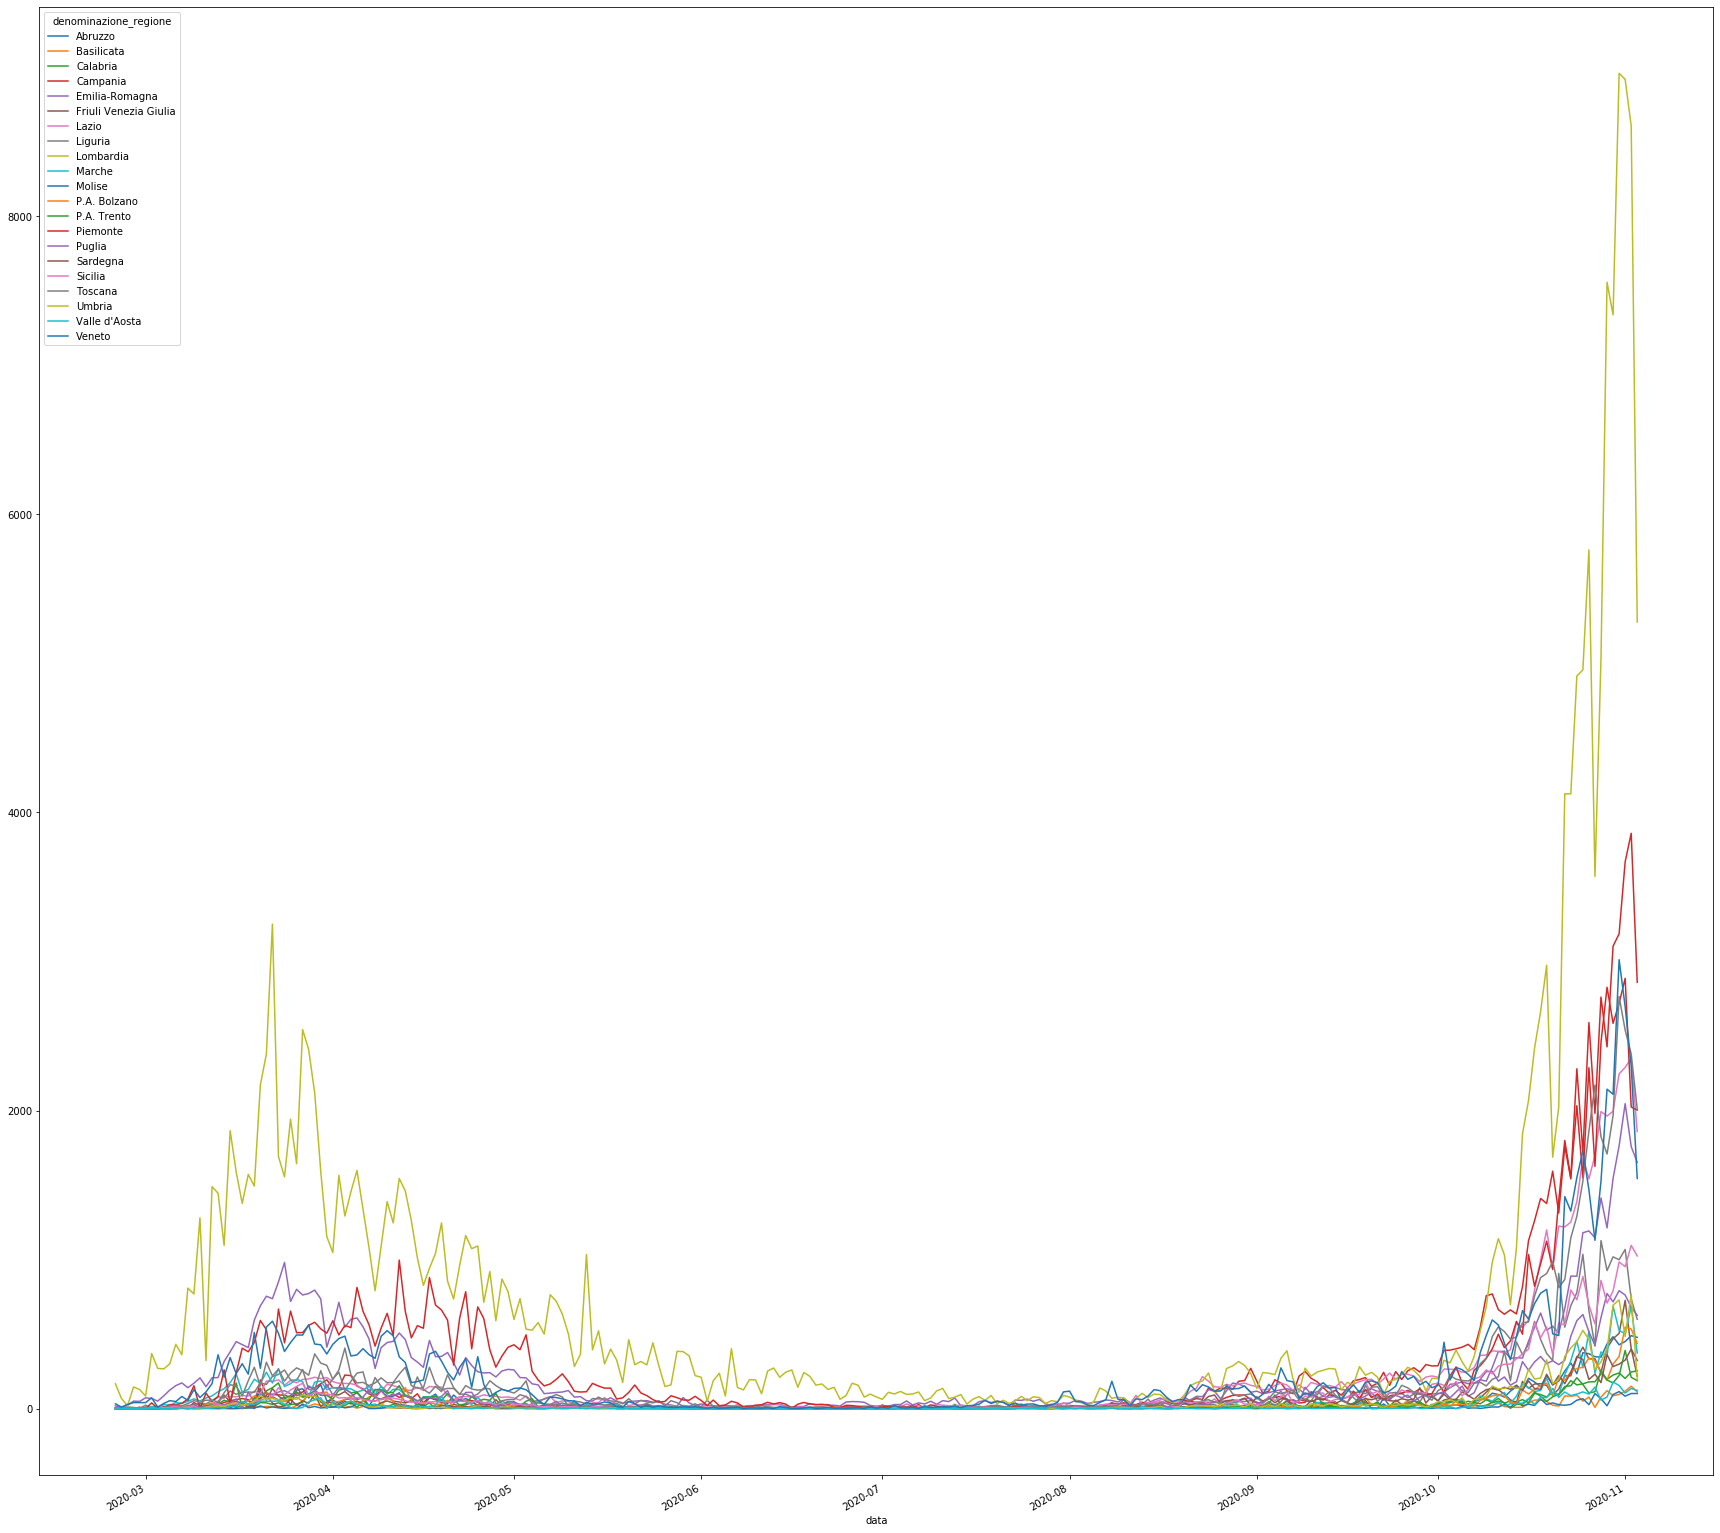

In [14]:
regions_raw_data.unstack(level=0).nuovi_positivi.plot(figsize=(30, 30))

In [15]:

regions_raw_data.loc[regions_raw_data.positivi_over_tamponi <0]

,,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,variazione_tamponi,positivi_over_tamponi
denominazione_regione,data,,,,,,,,,,,,,


[Text(0, 0, '(Piemonte, 2020-09-14 23:59:00)'),
 Text(0, 0, '(Piemonte, 2020-02-24 23:59:00)'),
 Text(0, 0, '(Piemonte, 2020-04-14 23:59:00)'),
 Text(0, 0, '(Piemonte, 2020-06-03 23:59:00)'),
 Text(0, 0, '(Piemonte, 2020-07-23 23:59:00)'),
 Text(0, 0, '(Piemonte, 2020-09-11 23:59:00)'),
 Text(0, 0, '(Piemonte, 2020-10-31 23:59:00)'),
 Text(0, 0, '')]

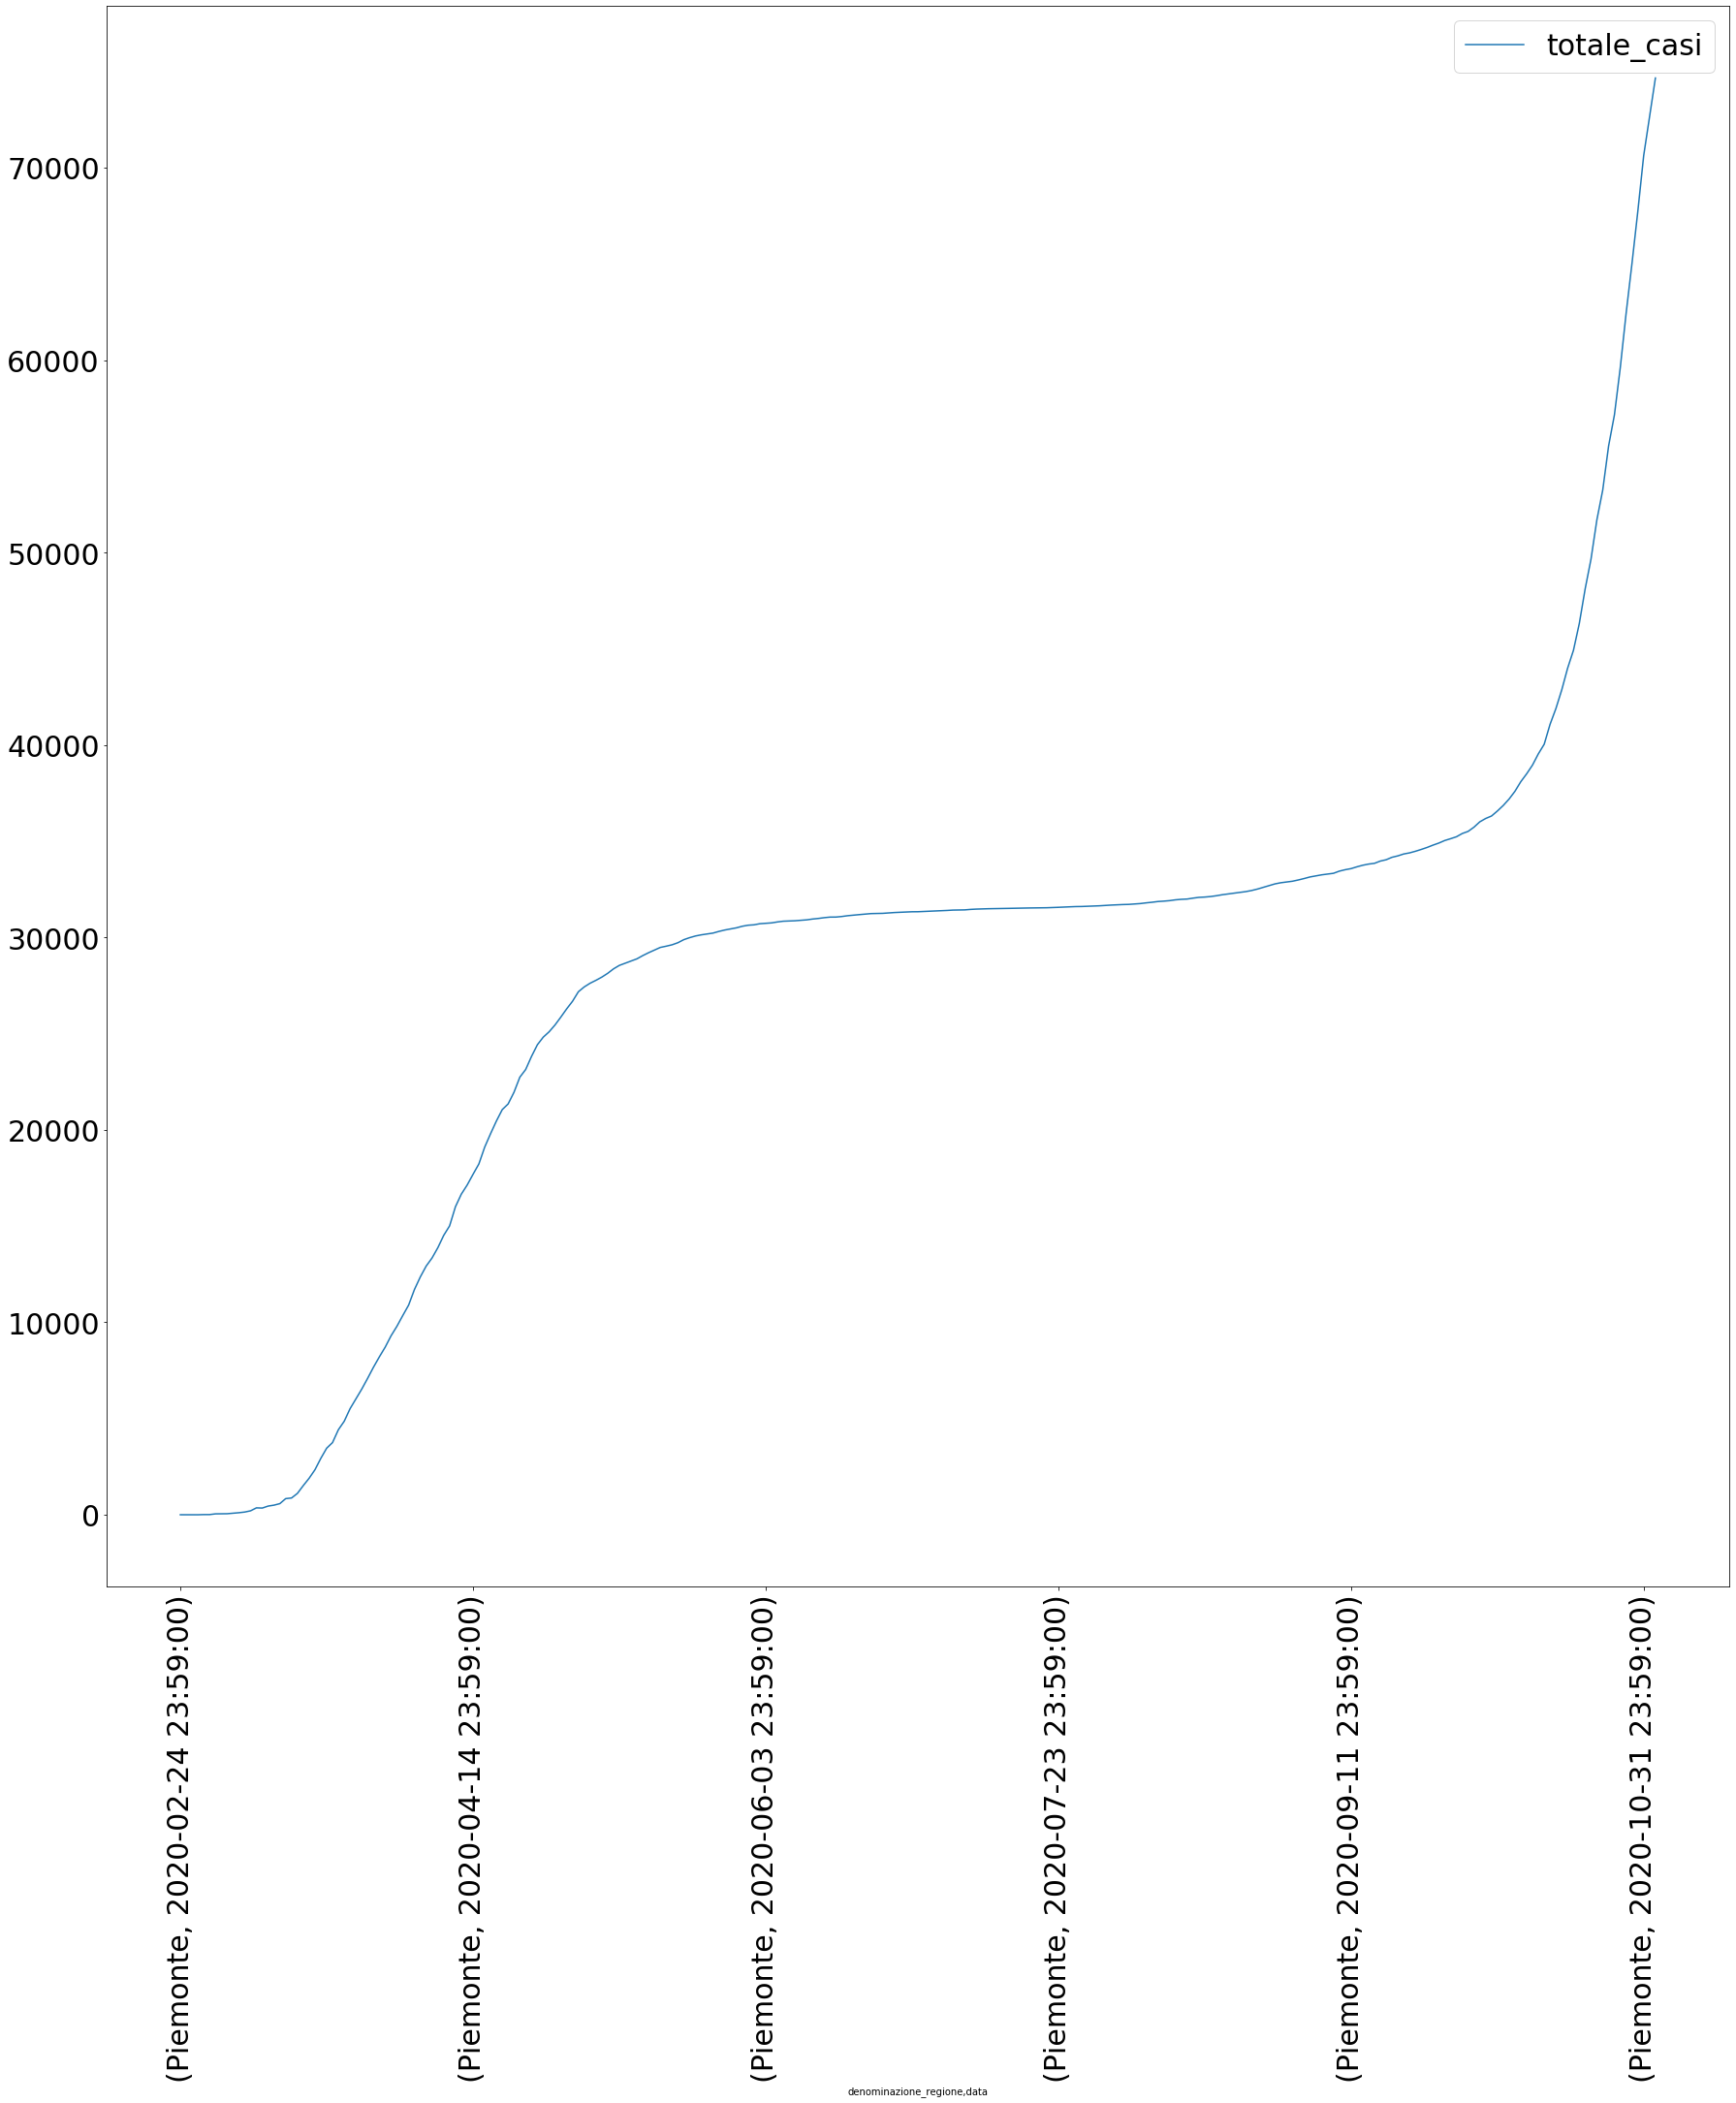

In [16]:
ax = regions_raw_data.loc[regions_raw_data.index.get_level_values("denominazione_regione")=='Piemonte', ['totale_casi']].plot(figsize=(30,30), fontsize=30)
ax.legend(fontsize=30)
lab = ax.get_xticklabels()
ax.set_xticklabels(lab, rotation=90)

In [17]:
TIMESTEPS = regions_raw_data.index.get_level_values('data').unique().shape[0]

In [18]:
def filter_matrices(timesteps):
    
    integral_matrix = np.tri(timesteps,timesteps,0)

    derivative_matrix = np.eye(timesteps,timesteps)-(np.tri(timesteps,timesteps,-1)-np.tri(timesteps,timesteps,-2))

    second_derivative_matrix = np.dot(derivative_matrix, derivative_matrix)
    
    return integral_matrix, second_derivative_matrix 


In [19]:
ALPHA = 100.

INTEGRAL_MATRIX, SECOND_DERIVATIVE_MATRIX = filter_matrices(TIMESTEPS)

GAMMA = SECOND_DERIVATIVE_MATRIX

In [20]:
def smooth_data(y, X, L, alpha):    
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.predict(X)

def smooth_differentiate(y, X, L, alpha):
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.coef_

In [21]:
piemonte = smooth_differentiate(
    regions_raw_data.loc[regions_raw_data.index.get_level_values('denominazione_regione')=='Piemonte', ['totale_casi']],
    INTEGRAL_MATRIX, GAMMA, ALPHA
)

TIC R2: 0.9999581502526333


In [22]:
regions_raw_data.loc[regions_raw_data.index.get_level_values('denominazione_regione')=='Piemonte',['totale_casi']]

totale_casi
denominazione_regione data                            
Piemonte              2020-02-24 23:59:00            3
                      2020-02-25 23:59:00            3
                      2020-02-26 23:59:00            3
                      2020-02-27 23:59:00            2
                      2020-02-28 23:59:00           11
...                                                ...
                      2020-10-29 23:59:00        65030
                      2020-10-30 23:59:00        67749
                      2020-10-31 23:59:00        70636
                      2020-11-01 23:59:00        72660
                      2020-11-02 23:59:00        74663

[253 rows x 1 columns]

In [23]:
regions_raw_data.index.get_level_values('data').unique()

DatetimeIndex(['2020-02-24 23:59:00', '2020-02-25 23:59:00',
               '2020-02-26 23:59:00', '2020-02-27 23:59:00',
               '2020-02-28 23:59:00', '2020-02-29 23:59:00',
               '2020-03-01 23:59:00', '2020-03-02 23:59:00',
               '2020-03-03 23:59:00', '2020-03-04 23:59:00',
               ...
               '2020-10-24 23:59:00', '2020-10-25 23:59:00',
               '2020-10-26 23:59:00', '2020-10-27 23:59:00',
               '2020-10-28 23:59:00', '2020-10-29 23:59:00',
               '2020-10-30 23:59:00', '2020-10-31 23:59:00',
               '2020-11-01 23:59:00', '2020-11-02 23:59:00'],
              dtype='datetime64[ns]', name='data', length=253, freq=None)

In [24]:
lombardia = smooth_differentiate(
    regions_raw_data.loc[regions_raw_data.index.get_level_values('denominazione_regione')=='Lombardia', ['totale_casi']],
    INTEGRAL_MATRIX, GAMMA, ALPHA
)

TIC R2: 0.9999247963780394


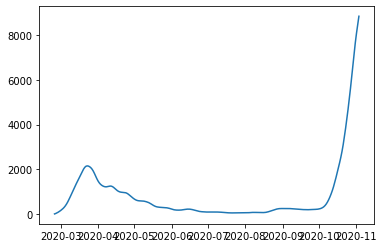

In [25]:
plt.plot(regions_raw_data.index.get_level_values('data').unique(), lombardia[0,:])

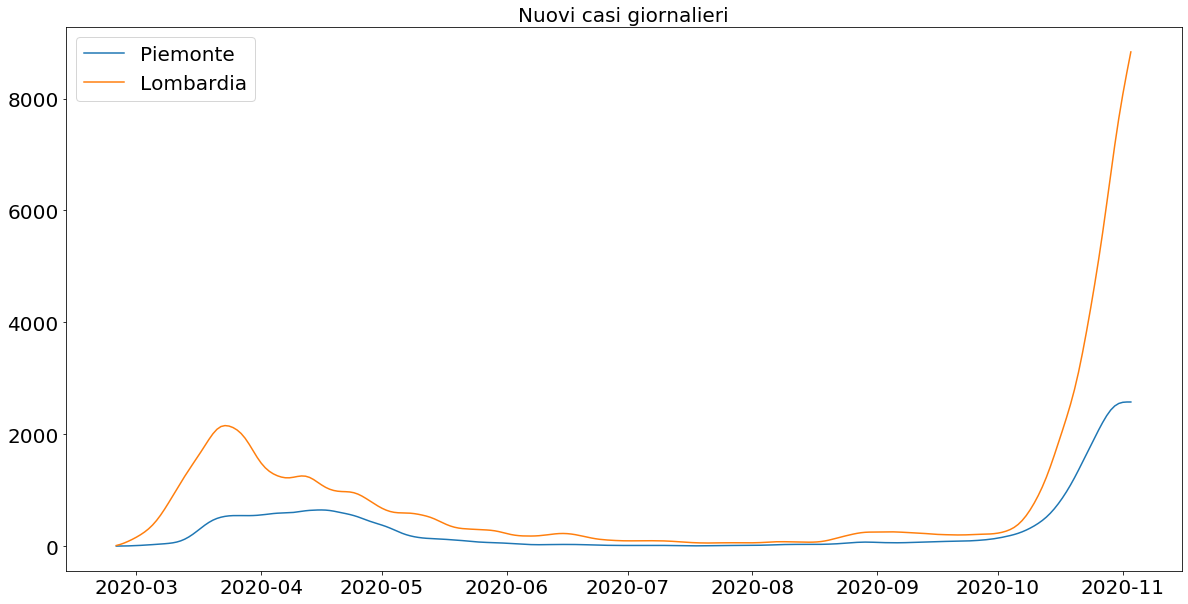

In [26]:
plt.figure(figsize=(20,10))
plt.title('Nuovi casi giornalieri', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(regions_raw_data.index.get_level_values('data').unique(), piemonte[0,:], label='Piemonte')
plt.plot(regions_raw_data.index.get_level_values('data').unique(), lombardia[0,:], label='Lombardia')
plt.legend(fontsize=20)

plt.show()

In [27]:
piemonte = regions_raw_data.loc[regions_raw_data.index.get_level_values('denominazione_regione')=='Piemonte']

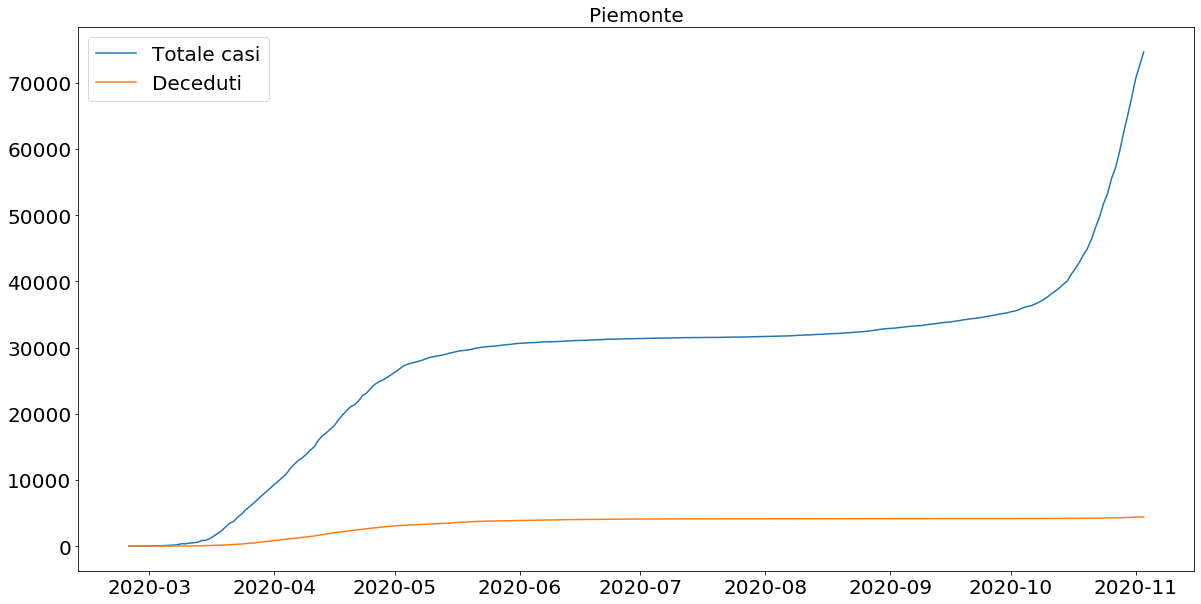

In [28]:
plt.figure(figsize=(20,10))
plt.title('Piemonte', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(regions_raw_data.index.get_level_values('data').unique(), piemonte.totale_casi, label='Totale casi')
plt.plot(regions_raw_data.index.get_level_values('data').unique(), piemonte.deceduti, label='Deceduti')
plt.legend(fontsize=20)

plt.show()

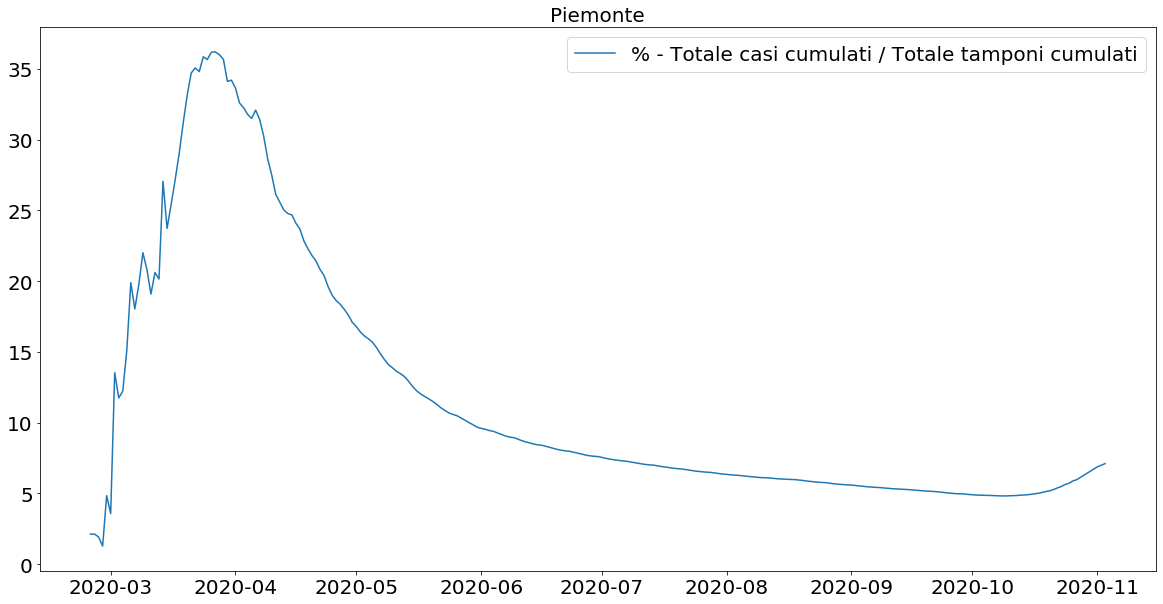

In [29]:
plt.figure(figsize=(20,10))
plt.title('Piemonte', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(regions_raw_data.index.get_level_values('data').unique(), piemonte.totale_casi/piemonte.tamponi*100, label='% - Totale casi cumulati / Totale tamponi cumulati')
plt.legend(fontsize=20)

plt.show()

In [30]:
piemonte.to_csv('piemonte.csv')

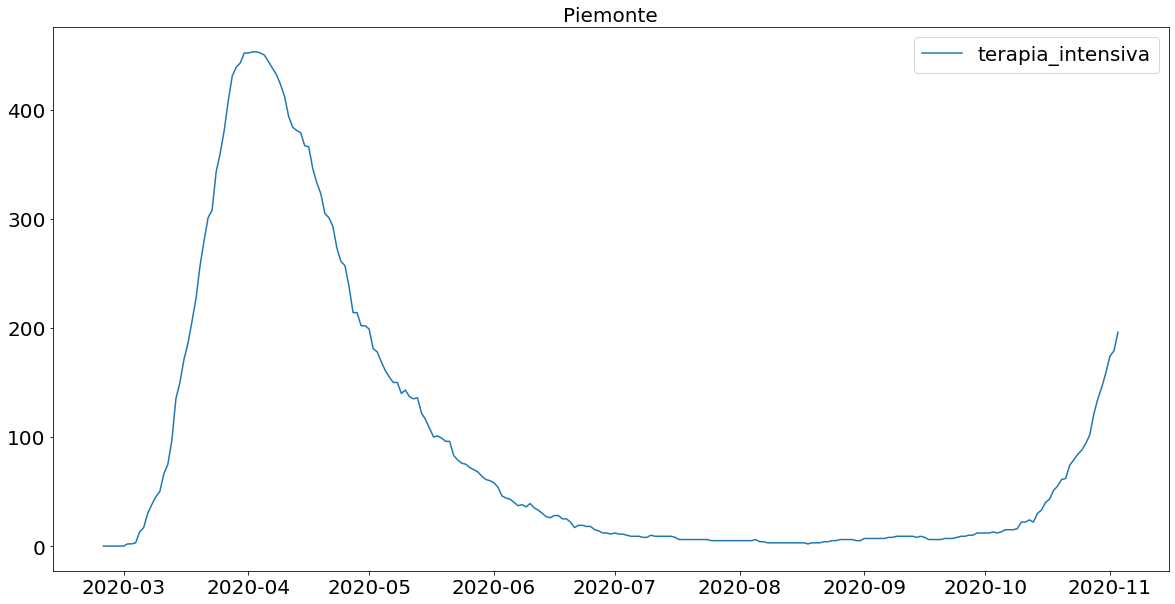

In [32]:
plt.figure(figsize=(20,10))
plt.title('Piemonte', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(regions_raw_data.index.get_level_values('data').unique(), piemonte.terapia_intensiva, label='terapia_intensiva')

plt.legend(fontsize=20)

plt.show()

In [33]:
piemonte['nuovi_casi_giornalieri_smoothed'] = smooth_differentiate(
    piemonte.totale_casi,
    INTEGRAL_MATRIX, GAMMA, ALPHA
)

piemonte['nuovi_deceduti_giornalieri_smoothed'] = smooth_differentiate(
    piemonte.deceduti,
    INTEGRAL_MATRIX, GAMMA, ALPHA
)

TIC R2: 0.9999581502526333
TIC R2: 0.9999843870350472


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


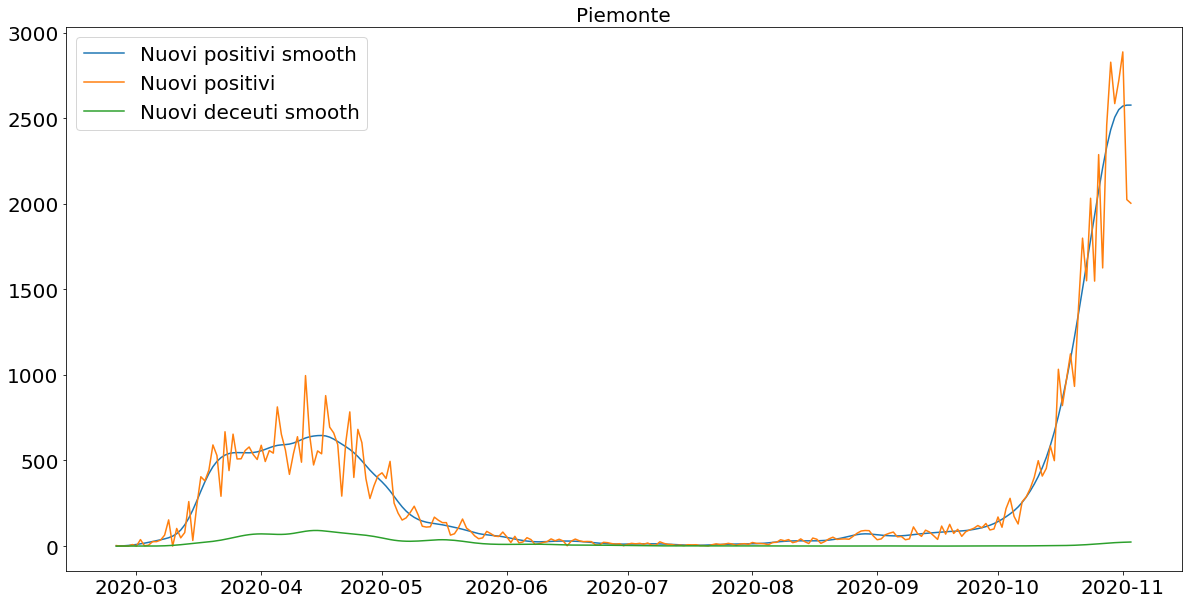

In [34]:
plt.figure(figsize=(20,10))
plt.title('Piemonte', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(regions_raw_data.index.get_level_values('data').unique(), piemonte.nuovi_casi_giornalieri_smoothed, label='Nuovi positivi smooth')
plt.plot(regions_raw_data.index.get_level_values('data').unique(), piemonte.nuovi_positivi, label='Nuovi positivi')
plt.plot(regions_raw_data.index.get_level_values('data').unique(), piemonte.nuovi_deceduti_giornalieri_smoothed, label='Nuovi deceuti smooth')

plt.legend(fontsize=20)

plt.show()

In [35]:
piemonte['nuovi_deceduti'] = piemonte.deceduti - piemonte.deceduti.shift(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


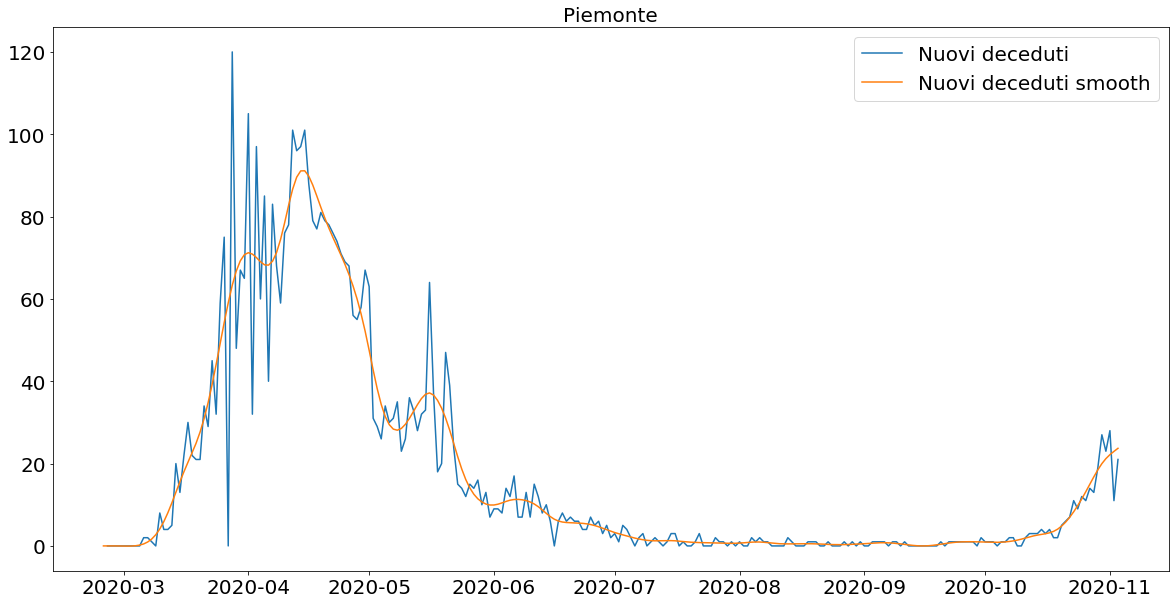

In [36]:
plt.figure(figsize=(20,10))
plt.title('Piemonte', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(regions_raw_data.index.get_level_values('data').unique(), piemonte.nuovi_deceduti, label='Nuovi deceduti')
plt.plot(regions_raw_data.index.get_level_values('data').unique(), piemonte.nuovi_deceduti_giornalieri_smoothed, label='Nuovi deceduti smooth')

plt.legend(fontsize=20)

plt.show()

In [37]:
regions_raw_data.index.droplevel('data').unique()

Index(['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia',
       'Sardegna', 'Sicilia', 'Toscana', 'Umbria', 'Valle d'Aosta', 'Veneto'],
      dtype='object', name='denominazione_regione')

In [38]:
regions_raw_data.rename(index={'Emilia-Romagna': 'Emilia Romagna'}, inplace=True)
trentino = regions_raw_data.loc[['P.A. Bolzano', 'P.A. Trento']].groupby('data').apply(sum).reset_index()
trentino['denominazione_regione'] = 'Trentino Alto Adige'
trentino.set_index(['denominazione_regione', 'data'], inplace=True)
regions_covid = regions_raw_data.drop(index=['P.A. Bolzano', 'P.A. Trento'])

regions_covid = pd.concat([regions_covid, trentino]).sort_index()

In [39]:
anziani = pd.read_csv('./data/sources/anziani_clean.csv')
anziani.rename(columns={'REGIONE':'denominazione_regione'}, inplace=True)
anziani.denominazione_regione = anziani.denominazione_regione.str.replace('-', ' ')
anziani.set_index('denominazione_regione', inplace=True)

In [40]:
assert(len(anziani.index.difference(regions_covid.index.droplevel('data')))==0)

In [41]:
max_cases = regions_covid.loc[:,['totale_casi']].groupby('denominazione_regione').apply(max)

In [42]:
max_cases = max_cases.merge(anziani.loc[:,['Popolazione_regione', 'Anziani_totali_in_RSA']], left_index=True, right_index=True)

In [43]:
max_cases['total_cases_over_population'] = max_cases.totale_casi / max_cases.Popolazione_regione
max_cases['elderly_in_NH_over_population'] = max_cases.Anziani_totali_in_RSA / max_cases.Popolazione_regione

max_cases.sort_values(by='elderly_in_NH_over_population', ascending=False, inplace=True)

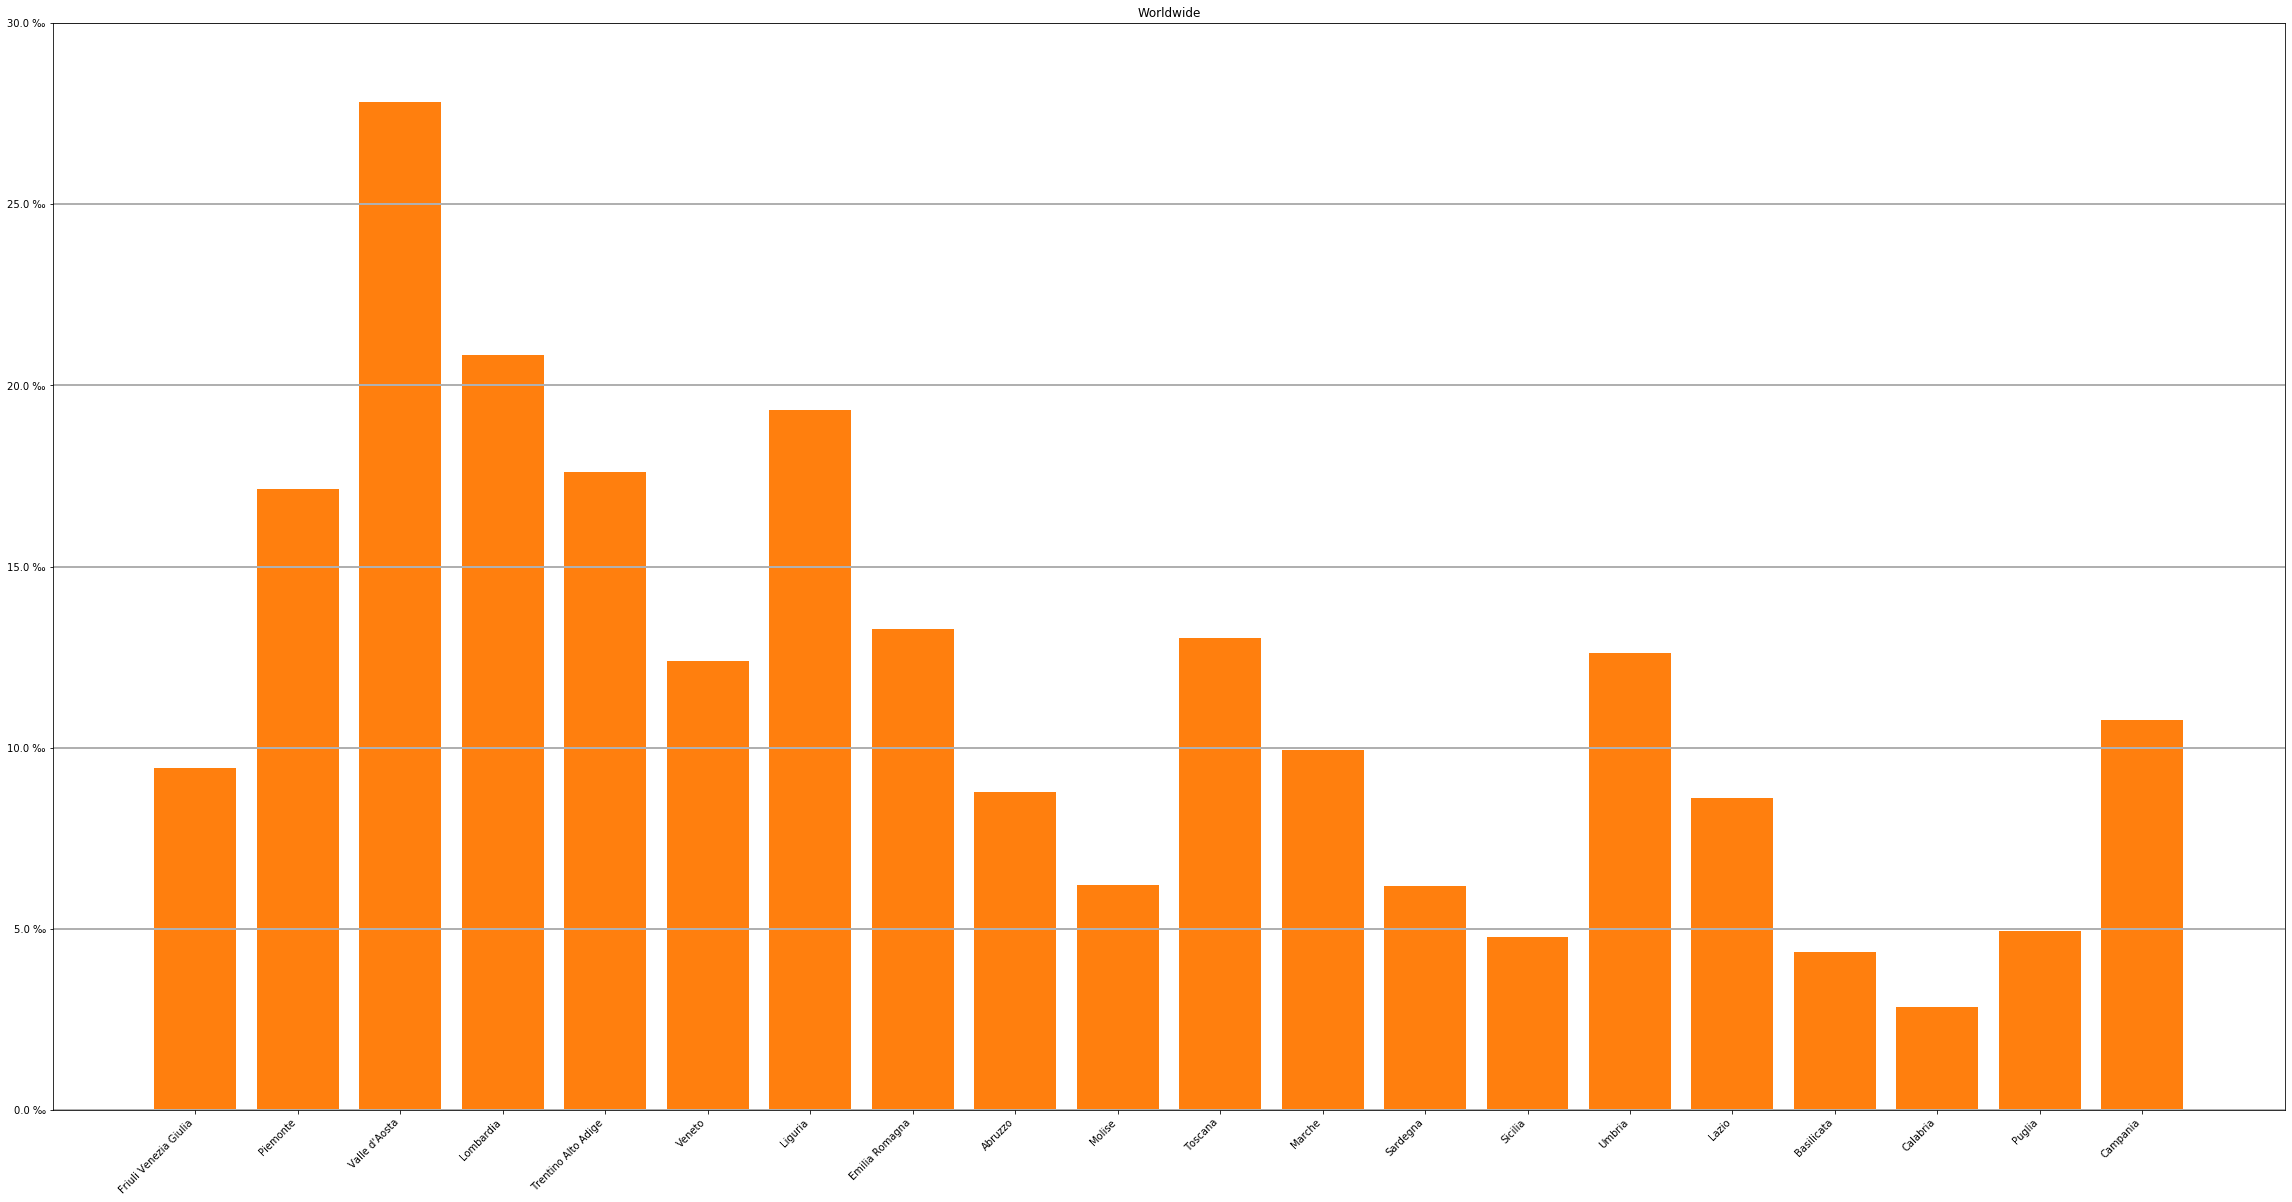

In [44]:
plt.figure(figsize=(40,20))

width = 0.27
plt.bar(max_cases.index.values, max_cases.loc[:,'elderly_in_NH_over_population'])

plt.bar(max_cases.index.values, max_cases.loc[:,'total_cases_over_population'])

#leg = plt.legend(['Elderly in NH per 1000 population'])
#leg = plt.legend(['Total cases per 1000 population'])


a=plt.xticks(rotation=45, ha='right')
yt,_=plt.yticks()
lbt=map(lambda t: str(t)+' ‰', np.round(yt*1000,2))
yt,_=plt.yticks(yt, lbt)
title = plt.title('Worldwide')

plt.grid(axis='y', linewidth=2)

In [45]:
max_cases.loc[:,['total_cases_over_population', 'elderly_in_NH_over_population']]

,total_cases_over_population,elderly_in_NH_over_population
denominazione_regione,,
Friuli Venezia Giulia,0.009432,0.009334
Piemonte,0.017139,0.008328
Valle d'Aosta,0.027828,0.007894
Lombardia,0.020837,0.007783
Trentino Alto Adige,0.017615,0.007765
Veneto,0.012393,0.007557
Liguria,0.019310,0.007149
Emilia Romagna,0.013286,0.006501
Abruzzo,0.008783,0.005887


In [46]:
def set_plot_fontsizes(SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE):
    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [47]:
set_plot_fontsizes(22, 30, 30)

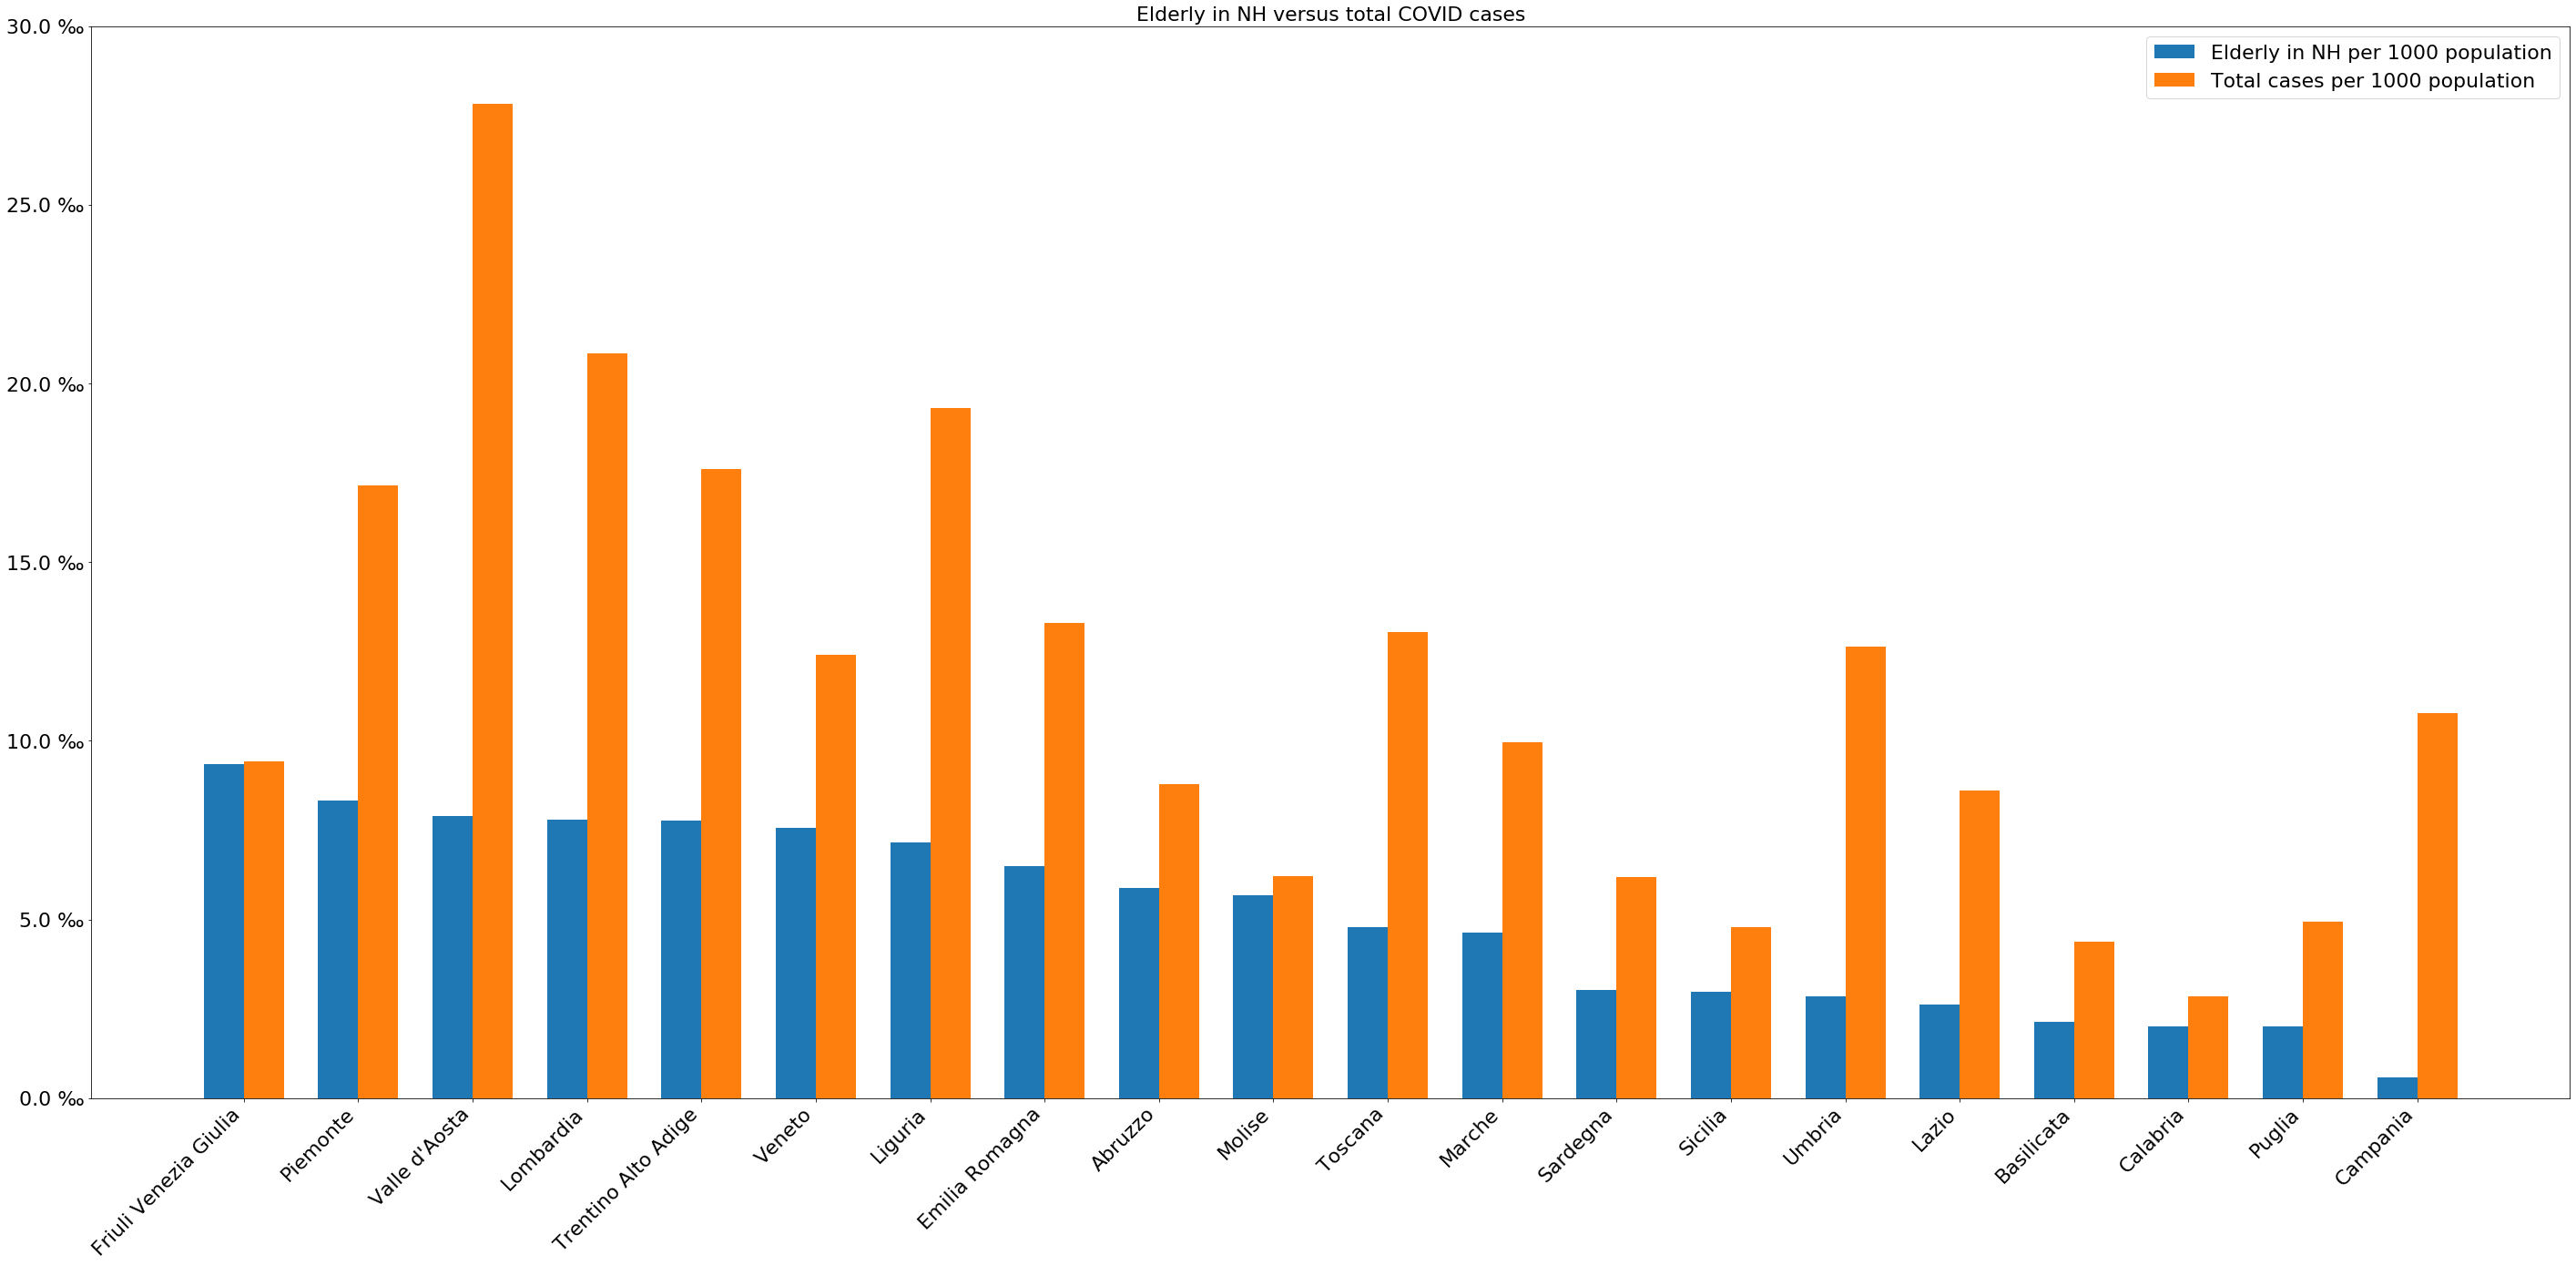

In [48]:
labels = max_cases.index.values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(40,20))

rects1 = ax.bar(x - width/2, max_cases.elderly_in_NH_over_population, width, label='Elderly in NH per 1000 population')
rects2 = ax.bar(x + width/2, max_cases.total_cases_over_population, width, label='Total cases per 1000 population')

# Add some text for labels, title and custom x-axis tick labels, etc.

a=plt.xticks(rotation=45, ha='right')
yt,_=plt.yticks()
lbt=map(lambda t: str(t)+' ‰', np.round(yt*1000,2))
yt,_=plt.yticks(yt, lbt)


ax.set_title('Elderly in NH versus total COVID cases')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)

fig.tight_layout()
plt.savefig('elderly_in_NH_versus_total_COVID_cases.png')

In [49]:
max_cases.elderly_in_NH_over_population.corr(max_cases.total_cases_over_population)

0.6630182551726549

$$ Corr(elderly\_in\_NH\_over\_population, total\_cases\_over\_population) = 0.78 $$

In [ ]:
max_cases.to_csv('piemonte_casi_totali_anzianiRSA_popolazione.csv')

In [ ]:
regions_raw_data.index.droplevel('denominazione_regione').max()